# iNaturalist

To get the data [iNaturalist Research-grade Observations](https://www.gbif.org/dataset/50c9509d-22c7-4a22-a47d-8c48425ef4a7) run this in the terminal


```bash
mkdir data
cd data
wget https://api.gbif.org/v1/occurrence/download/request/0011012-251025141854904.zip
unzip 0011012-251025141854904.zip
```

In [ ]:
# ! pip install xarray cfgrib eccodes --quiet

  DEPRECATION: Building 'moviepy' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'moviepy'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'asciitree' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'asciitree'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [1]:
import duckdb
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMapWithTime

from sklearn.neighbors import BallTree
from datetime import datetime
import torch
from torch.nn.functional import normalize
from chronos import BaseChronosPipeline, Chronos2Pipeline, ChronosPipeline
pd.set_option('display.max_columns', None)

In [2]:
con = duckdb.connect('/network/scratch/g/guzmand/Fall-2025/COMP-685-ML-for-Climate-Change/data/iNaturalist.duckdb')
print("connected!")

connected!


In [2]:
# con = duckdb.connect('data/iNaturalist.duckdb')
# print("connected!")

connected!


In [3]:
# # Run this only once

# # Create or connect to a persistent DB
# con = duckdb.connect('data/iNaturalist.duckdb')
# print("connected")

# # Import TSV once
# con.execute("""
#     CREATE TABLE IF NOT EXISTS iNaturalist AS
#         SELECT * 
#         FROM read_csv_auto('data/0011012-251025141854904.csv', sep='\t', header=True);
# """)
# print("created iNaturalist.duckdb")

# # Optionally add indexes
# con.execute("PRAGMA enable_object_cache;")
# print("add indexes")


# # Query repeatedly without rereading the TSV
# result = con.execute("""
#     SELECT COUNT(*)
#     FROM iNaturalist

# """).df()

# result.head()

In [3]:
query = """
SELECT COUNT(*) AS observation_count
FROM iNaturalist
"""
df = con.execute(query).df()
df

,observation_count
0,131470382


In [4]:
query = """
SELECT DISTINCT individualCount
FROM iNaturalist
LIMIT 5
"""
df = con.execute(query).df()
df

,individualCount
0,None


In [5]:
query = """
SELECT *
FROM iNaturalist
LIMIT 5
"""
df = con.execute(query).df()
df

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,4868040692,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18469...,Plantae,Tracheophyta,Magnoliopsida,Lamiales,Linderniaceae,Torenia,Torenia concolor,None,SPECIES,Torenia concolor Lindl.,Torenia concolor,None,TW,None,Taiwan,PRESENT,None,28eb1a3f-1c15-4a95-931a-4af90ecb574d,23.912801,120.887476,NaN,None,None,None,None,None,2023-09-24T10:00,24,9,2023,7331731,7331731,HUMAN_OBSERVATION,iNaturalist,Observations,184692892,None,祐,2023-09-24 14:10:04,CC_BY_4_0,祐,祐,None,None,2025-10-27 18:16:30.103000-04:00,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...
1,4416978367,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18476...,Plantae,Tracheophyta,Magnoliopsida,Ericales,Primulaceae,Samolus,Samolus parviflorus,None,SPECIES,Samolus parviflorus Raf.,Samolus parviflorus,None,US,None,Indiana,PRESENT,None,28eb1a3f-1c15-4a95-931a-4af90ecb574d,40.192580,-85.400362,34.0,None,None,None,None,None,2023-09-24T15:57:17,24,9,2023,4005796,4005796,HUMAN_OBSERVATION,iNaturalist,Observations,184760814,None,lsodo,2023-09-24 20:48:04,CC_BY_NC_4_0,lsodo,lsodo,None,None,2025-10-27 18:16:31.279000-04:00,StillImage;StillImage;StillImage;StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...
2,2634468672,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/47367680,Animalia,Arthropoda,Diplopoda,Polydesmida,Xystodesmidae,Harpaphe,Harpaphe haydeniana,None,SPECIES,"Harpaphe haydeniana (Wood, 1864)",Harpaphe haydeniana,None,US,None,California,PRESENT,None,28eb1a3f-1c15-4a95-931a-4af90ecb574d,37.262108,-122.241436,NaN,None,None,None,None,None,2020-05-24T16:33:17,24,5,2020,4303100,4303100,HUMAN_OBSERVATION,iNaturalist,Observations,47367680,None,Geert Barentsen,2020-05-26 04:29:42,CC_BY_4_0,Geert Barentsen,Geert Barentsen,None,None,2025-10-27 20:04:21.869000-04:00,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...
3,2634039778,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/47438627,Animalia,Arthropoda,Insecta,Hymenoptera,Eumenidae,Polistes,Polistes dominula,None,SPECIES,"Polistes dominula (Christ, 1791)",Polistes dominula,None,US,None,New York,PRESENT,None,28eb1a3f-1c15-4a95-931a-4af90ecb574d,40.701724,-73.996270,NaN,None,None,None,None,None,2020-05-26T11:07:43,26,5,2020,5871389,5871389,HUMAN_OBSERVATION,iNaturalist,Observations,47438627,None,Paweł Pieluszyński,2020-05-26 20:24:18,CC_BY_NC_4_0,Paweł Pieluszyński,Paweł Pieluszyński,None,None,2025-10-27 20:04:22.711000-04:00,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...
4,2634063924,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/47524180,Animalia,Chordata,Aves,Anseriformes,Anatidae,Mergus,Mergus merganser,None,SPECIES,"Mergus merganser Linnaeus, 1758",Mergus merganser,None,US,None,Oregon,PRESENT,None,28eb1a3f-1c15-4a95-931a-4af90ecb574d,45.501143,-122.306145,181.0,None,None,None,None,None,2020-05-08,8,5,2020,9537647,9537647,HUMAN_OBSERVATION,iNaturalist,Observations,47524180,None,Fern Wexler,2020-05-27 16:26:06,CC_BY_NC_4_0,Fern Wexler,Fern Wexler,None,None,2025-10-27 20:04:23.298000-04:00,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...


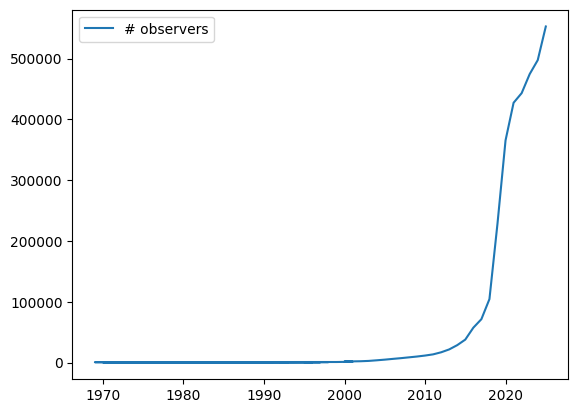

In [6]:
query = """
SELECT year, COUNT(DISTINCT recordedBy) AS nObservers
FROM iNaturalist
GROUP BY year
ORDER BY nObservers DESC
LIMIT 50
"""
df = con.execute(query).df()

plt.plot(df["year"], df["nObservers"], label="# observers")
plt.legend()
plt.show()

In [7]:
query = """
SELECT recordedBy, COUNT(*) AS CountNumber
FROM iNaturalist
GROUP BY recordedBy
ORDER BY CountNumber DESC
LIMIT 10
"""
df = con.execute(query).df()
df

,recordedBy,CountNumber
0,CK2AZ,278590
1,Reiner Richter,233625
2,John D Reynolds,229400
3,Tony Rebelo,207379
4,Jon McIntyre,149477
5,Sam Kieschnick,137614
6,Sara Rall,130577
7,Alexey P. Seregin,124054
8,Craig Peter,119046
9,Stephen James McWilliam,110194


In [8]:
query = """
SELECT verbatimScientificName, COUNT(*) AS observation_count
FROM iNaturalist
GROUP BY verbatimScientificName
ORDER BY observation_count DESC
"""

df = con.execute(query).df()
df

,verbatimScientificName,observation_count
0,Anas platyrhynchos,491873
1,Apis mellifera,422116
2,Harmonia axyridis,317456
3,Passer domesticus,306767
4,Danaus plexippus,295071
...,...,...
483352,Neohelvibotys polingi,1
483353,Polykatianna radicula,1
483354,Tarache bilimeki,1
483355,Hauptidia lapidicola,1


In [8]:
# query = """
# SELECT 
#     verbatimScientificName,
#     STRFTIME(
#         TRY_STRPTIME(eventDate, ['%Y-%m-%dT%H:%M:%S', '%Y-%m-%dT%H:%M', '%Y-%m-%d']),
#         '%Y-%m-%d %H:%M:%S'
#     ) AS eventDate,
#     decimalLatitude,
#     decimalLongitude,
#     countryCode
# FROM iNaturalist
# WHERE 
#     decimalLatitude IS NOT NULL
#     AND decimalLongitude IS NOT NULL
#     AND eventDate IS NOT NULL
# LIMIT 10
# """

# df = con.execute(query).df()
# df

In [9]:
# Aggregate by date and time
query = """
WITH clean_iNaturalist AS (
    SELECT
        verbatimScientificName,
        STRFTIME(
            TRY_STRPTIME(eventDate, ['%Y-%m-%dT%H:%M:%S', '%Y-%m-%dT%H:%M', '%Y-%m-%d']),
            '%Y-%m-%d %H:%M:%S'
        ) AS dateOcurrence,  -- keep full datetime
        decimalLatitude,
        decimalLongitude,
        countryCode
    FROM iNaturalist
    WHERE
        decimalLatitude IS NOT NULL
        AND decimalLongitude IS NOT NULL
        AND eventDate IS NOT NULL AND TRIM(eventDate) <> ''
        AND TRY_STRPTIME(eventDate, ['%Y-%m-%dT%H:%M:%S', '%Y-%m-%dT%H:%M', '%Y-%m-%d']) > TIMESTAMP '2000-01-01'
        AND verbatimScientificName = 'Danaus plexippus'
)

SELECT
    verbatimScientificName,
    dateOcurrence,
    decimalLatitude,
    decimalLongitude,
    countryCode,
    COUNT(*) AS countOccurrences
FROM clean_iNaturalist
GROUP BY
    verbatimScientificName,
    dateOcurrence,
    decimalLatitude,
    decimalLongitude,
    countryCode
ORDER BY
    dateOcurrence;
"""

df = con.execute(query).df()
df


,verbatimScientificName,dateOcurrence,decimalLatitude,decimalLongitude,countryCode,countOccurrences
0,Danaus plexippus,2000-01-29 19:46:00,35.263600,-120.638700,US,1
1,Danaus plexippus,2000-01-29 20:14:00,35.263712,-120.638812,US,1
2,Danaus plexippus,2000-01-29 20:15:00,35.263638,-120.638652,US,1
3,Danaus plexippus,2000-02-28 21:44:00,20.607068,-103.341398,MX,1
4,Danaus plexippus,2000-04-27 16:20:00,36.099136,-112.089027,US,1
...,...,...,...,...,...,...
280161,Danaus plexippus,2025-10-21 17:05:35,33.012233,-83.734720,US,1
280162,Danaus plexippus,2025-10-21 17:19:44,33.465848,-82.230231,US,1
280163,Danaus plexippus,2025-10-21 17:30:21,36.704885,-76.236060,US,1
280164,Danaus plexippus,2025-10-21 18:22:53,-32.340301,116.013917,AU,1


In [10]:
query = """
WITH clean_iNaturalist AS (
    SELECT
        verbatimScientificName,
        STRFTIME(
            TRY_STRPTIME(eventDate, ['%Y-%m-%dT%H:%M:%S', '%Y-%m-%dT%H:%M', '%Y-%m-%d']),
            '%Y-%m-%d'
        ) AS dateOcurrence,  -- keep only the date part
        decimalLatitude,
        decimalLongitude,
        countryCode
    FROM iNaturalist
    WHERE
        decimalLatitude IS NOT NULL
        AND decimalLongitude IS NOT NULL
        AND eventDate IS NOT NULL AND TRIM(eventDate) <> '' 
        AND dateOcurrence IS NOT NULL AND TRIM(dateOcurrence) <> ''
        AND TRY_STRPTIME(eventDate, ['%Y-%m-%dT%H:%M:%S', '%Y-%m-%dT%H:%M', '%Y-%m-%d']) > TIMESTAMP '2020-01-01'
        AND verbatimScientificName = 'Danaus plexippus'
        AND countryCode IN ('US', 'CA', 'MX')
)

SELECT
    verbatimScientificName,
    dateOcurrence,
    decimalLatitude,
    decimalLongitude,
    countryCode,
    COUNT(*) AS countOccurrences
FROM clean_iNaturalist
GROUP BY
    verbatimScientificName,
    dateOcurrence,
    decimalLatitude,
    decimalLongitude,
    countryCode
ORDER BY
    dateOcurrence;
"""
df = con.execute(query).df()
df["dateOcurrence"] = pd.to_datetime(df["dateOcurrence"])
df


,verbatimScientificName,dateOcurrence,decimalLatitude,decimalLongitude,countryCode,countOccurrences
0,Danaus plexippus,2020-01-01,25.670564,-80.391387,US,1
1,Danaus plexippus,2020-01-01,25.139642,-80.930674,US,1
2,Danaus plexippus,2020-01-01,37.843267,-122.284744,US,1
3,Danaus plexippus,2020-01-01,33.782766,-118.348055,US,1
4,Danaus plexippus,2020-01-01,26.411567,-81.891830,US,1
...,...,...,...,...,...,...
206320,Danaus plexippus,2025-10-21,30.531222,-97.573137,US,1
206321,Danaus plexippus,2025-10-21,33.012233,-83.734720,US,1
206322,Danaus plexippus,2025-10-21,38.682352,-123.423804,US,1
206323,Danaus plexippus,2025-10-21,37.885391,-122.297589,US,1


## Maps

In [ ]:
# import pandas as pd
# import folium
# from folium.plugins import HeatMapWithTime

# # Group by date
# time_index = sorted(df["dateOcurrence"].unique())

# # Create list of lists [[lat, lon, weight], ...] for each date
# heat_data = [
#     df[df["dateOcurrence"] == date][["decimalLatitude", "decimalLongitude", "countOccurrences"]].values.tolist()
#     for date in time_index
# ]

# # Initialize Folium map centered around average coordinates
# m = folium.Map(
#     location=[df["decimalLatitude"].mean(), df["decimalLongitude"].mean()],
#     zoom_start=4,
#     tiles="CartoDB dark_matter"
# )

# # Add time heatmap
# HeatMapWithTime(
#     data=heat_data,
#     index=[str(d.date()) for d in time_index],
#     radius=25,
#     auto_play=True,
#     max_opacity=0.8
# ).add_to(m)

# # Save or display map
# m.save("monarch_time_heatmap.html")
# m

In [12]:
# Extract week and year
df["year"] = df["dateOcurrence"].dt.isocalendar().year
df["week"] = df["dateOcurrence"].dt.isocalendar().week

# Compute last day (Sunday) of each ISO week
df["week_end"] = df["dateOcurrence"].apply(lambda x: x + pd.offsets.Week(weekday=6))
df["week_end_str"] = df["week_end"].dt.strftime("%Y-%m-%d")

# Group by week ending date and coordinates
weekly = (
    df.groupby(["week_end_str", "decimalLatitude", "decimalLongitude"], as_index=False)
      .agg({"countOccurrences": "sum"})
)

# Prepare time-indexed heatmap frames
time_index = sorted(weekly["week_end_str"].unique())
heat_data = [
    weekly[weekly["week_end_str"] == week][["decimalLatitude", "decimalLongitude", "countOccurrences"]].values.tolist()
    for week in time_index
]

# Initialize map
m = folium.Map(
    location=[df["decimalLatitude"].mean(), df["decimalLongitude"].mean()],
    zoom_start=4,
    tiles="CartoDB dark_matter"
)

HeatMapWithTime(
    data=heat_data,
    index=time_index,
    radius=20,
    auto_play=True,
    max_opacity=0.8,
    use_local_extrema=True,
    min_speed=5,  # minimum speed (frames per second)
    max_speed=10,
    speed_step=1,
    display_index=True
).add_to(m)

# Enlarge time slider bar for readability
css = """
<style>
.leaflet-control-container .leaflet-bottom.leaflet-left {
    transform: scale(1.4);
    transform-origin: bottom left;
    margin-bottom: 30px;
}
</style>
"""
m.get_root().html.add_child(folium.Element(css))

# Save or display
m.save("monarch_weekly_heatmap.html")


## Grid ID mapping

- `gbifID` is unique to every observation, so I can index this column for better performance and create a new mapping table to get to which `grid_id` it belongs.

In [13]:
query = """
SELECT *
FROM iNaturalist
LIMIT 2
"""
df = con.execute(query).df()
df

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,4868040692,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18469...,Plantae,Tracheophyta,Magnoliopsida,Lamiales,Linderniaceae,Torenia,Torenia concolor,None,SPECIES,Torenia concolor Lindl.,Torenia concolor,None,TW,None,Taiwan,PRESENT,None,28eb1a3f-1c15-4a95-931a-4af90ecb574d,23.912801,120.887476,NaN,None,None,None,None,None,2023-09-24T10:00,24,9,2023,7331731,7331731,HUMAN_OBSERVATION,iNaturalist,Observations,184692892,None,祐,2023-09-24 14:10:04,CC_BY_4_0,祐,祐,None,None,2025-10-27 18:16:30.103000-04:00,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...
1,4416978367,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18476...,Plantae,Tracheophyta,Magnoliopsida,Ericales,Primulaceae,Samolus,Samolus parviflorus,None,SPECIES,Samolus parviflorus Raf.,Samolus parviflorus,None,US,None,Indiana,PRESENT,None,28eb1a3f-1c15-4a95-931a-4af90ecb574d,40.192580,-85.400362,34.0,None,None,None,None,None,2023-09-24T15:57:17,24,9,2023,4005796,4005796,HUMAN_OBSERVATION,iNaturalist,Observations,184760814,None,lsodo,2023-09-24 20:48:04,CC_BY_NC_4_0,lsodo,lsodo,None,None,2025-10-27 18:16:31.279000-04:00,StillImage;StillImage;StillImage;StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...


In [14]:
query = """
WITH iNaturalist_coordinates AS (
    SELECT DISTINCT gbifID, decimalLatitude, decimalLongitude
    FROM iNaturalist
)
SELECT *
FROM iNaturalist_coordinates
"""
iNaturalist_coordinates = con.execute(query).df()
iNaturalist_coordinates

,gbifID,decimalLatitude,decimalLongitude
0,4500616861,33.675415,-115.771812
1,4407122807,50.975658,-114.034783
2,4923820376,42.461422,-71.091155
3,4405419302,43.713790,7.283009
4,3773372369,50.417323,30.547224
...,...,...,...
131470377,2826336112,39.888477,-75.258162
131470378,1269565667,20.411843,-100.074898
131470379,2350301874,-18.666911,24.499347
131470380,5827661256,41.891423,-73.151547


In [23]:
query = """
SELECT latitude, longitude, grid_id
FROM era5_grid
ORDER BY latitude, longitude
"""
era5_grid = con.execute(query).df()
era5_grid

NameError: name 'con' is not defined

In [ ]:
era5_grid.to_csv("grid_map.csv")

In [ ]:
# Convert degrees to radians
iNat_coords = np.radians(iNaturalist_coordinates[['decimalLatitude', 'decimalLongitude']])
era5_coords = np.radians(era5_grid[['latitude', 'longitude']])

# Build BallTree using Haversine metric (expects radians)
print("Building BallTree")
tree = BallTree(era5_coords, metric='haversine')

# Query nearest neighbor (returns distance in radians)
print("Query nearest neighbor in iNat_coords")
distances, indices = tree.query(iNat_coords, k=1)

# Get nearest grid_id for each iNaturalist point
print("Get nearest grid_id")
nearest_grid_ids = era5_grid.iloc[indices.flatten()]['grid_id'].values

# Add nearest_grid_id column
iNaturalist_coordinates['nearest_grid_id'] = nearest_grid_ids

# Convert Haversine distance to km
earth_radius_km = 6371
iNaturalist_coordinates['distance_km'] = distances.flatten() * earth_radius_km

iNaturalist_coordinates.head()

Building BallTree
Query nearest neighbor in iNat_coords


In [42]:
# Create the grid table in DuckDB
con.execute("CREATE TABLE IF NOT EXISTS iNaturalist_grid_mapping AS SELECT * FROM iNaturalist_coordinates")

print("Table 'iNaturalist_grid_mapping' created successfully!")

Table 'iNaturalist_grid_mapping' created successfully!


# Join with ERA5

In [11]:
query = """
SELECT *
FROM iNaturalist
LIMIT 2
"""
df = con.execute(query).df()
df

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,4868040692,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18469...,Plantae,Tracheophyta,Magnoliopsida,Lamiales,Linderniaceae,Torenia,Torenia concolor,None,SPECIES,Torenia concolor Lindl.,Torenia concolor,None,TW,None,Taiwan,PRESENT,None,28eb1a3f-1c15-4a95-931a-4af90ecb574d,23.912801,120.887476,NaN,None,None,None,None,None,2023-09-24T10:00,24,9,2023,7331731,7331731,HUMAN_OBSERVATION,iNaturalist,Observations,184692892,None,祐,2023-09-24 14:10:04,CC_BY_4_0,祐,祐,None,None,2025-10-27 18:16:30.103000-04:00,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...
1,4416978367,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/18476...,Plantae,Tracheophyta,Magnoliopsida,Ericales,Primulaceae,Samolus,Samolus parviflorus,None,SPECIES,Samolus parviflorus Raf.,Samolus parviflorus,None,US,None,Indiana,PRESENT,None,28eb1a3f-1c15-4a95-931a-4af90ecb574d,40.192580,-85.400362,34.0,None,None,None,None,None,2023-09-24T15:57:17,24,9,2023,4005796,4005796,HUMAN_OBSERVATION,iNaturalist,Observations,184760814,None,lsodo,2023-09-24 20:48:04,CC_BY_NC_4_0,lsodo,lsodo,None,None,2025-10-27 18:16:31.279000-04:00,StillImage;StillImage;StillImage;StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...


In [12]:
query = """
SELECT *
FROM iNaturalist_grid_mapping
LIMIT 2
"""
df = con.execute(query).df()
df

,gbifID,decimalLatitude,decimalLongitude,nearest_grid_id,distance_km
0,4458454027,25.657259,-100.370267,667759,15.860073
1,4919444439,11.403266,107.374610,585069,17.323955


In [13]:
query = """
SELECT *
FROM ERA5_Daily
LIMIT 2
"""
df = con.execute(query).df()
df

,valid_time,latitude,longitude,u10,number,v10,d2m,t2m,msl,mwd,mwp,sst,swh,sp,tp
0,2020-01-01,-90.0,0.00,0.532273,0,0.02559,242.739258,246.011063,99628.21875,NaN,NaN,NaN,NaN,68844.367188,4.569689e-07
1,2020-01-01,-90.0,0.25,0.532273,0,0.02559,242.739258,246.011063,99628.21875,NaN,NaN,NaN,NaN,68844.367188,4.569689e-07


In [14]:
query = """
SELECT *
FROM ERA5_grid
LIMIT 2
"""
df = con.execute(query).df()
df

,latitude,longitude,grid_id
0,-90.0,0.00,0
1,-90.0,0.25,1


In [3]:
verbatimScientificName = "Danaus plexippus"
min_date = "2020-01-01"

query = f"""
WITH filtered_iNaturalist AS (
    SELECT
        gbifID,
        verbatimScientificName,
        STRFTIME(
            TRY_STRPTIME(eventDate, ['%Y-%m-%dT%H:%M:%S', '%Y-%m-%dT%H:%M', '%Y-%m-%d']),
            '%Y-%m-%d'
        ) AS dateOcurrence,  -- keep only the date part
        decimalLatitude,
        decimalLongitude,
        countryCode
    FROM iNaturalist
    WHERE
        decimalLatitude IS NOT NULL
        AND decimalLongitude IS NOT NULL
        AND eventDate IS NOT NULL AND TRIM(eventDate) <> '' 
        AND dateOcurrence IS NOT NULL AND TRIM(dateOcurrence) <> ''
        AND TRY_STRPTIME(eventDate, ['%Y-%m-%dT%H:%M:%S', '%Y-%m-%dT%H:%M', '%Y-%m-%d']) > '{min_date}'
        AND verbatimScientificName = '{verbatimScientificName}'
        AND countryCode IN ('US', 'CA', 'MX')
),

mapped_iNaturalist AS (
    SELECT
        filtered_iNaturalist.verbatimScientificName,
        CAST(filtered_iNaturalist.dateOcurrence AS DATE) AS dateOcurrence,
        filtered_iNaturalist.decimalLatitude,
        filtered_iNaturalist.decimalLongitude,
        filtered_iNaturalist.countryCode,
        iNaturalist_grid_mapping.nearest_grid_id
    FROM filtered_iNaturalist AS filtered_iNaturalist
    JOIN iNaturalist_grid_mapping AS iNaturalist_grid_mapping
    USING (gbifID)
),

filtered_ERA5 AS (
    SELECT 
        valid_time,
        latitude,
        longitude,
        u10,
        v10,
        d2m,
        t2m,
        msl,
        mwd,
        mwp,
        sst,
        swh,
        sp,
        tp
    FROM ERA5_Daily
    WHERE 
        valid_time > '{min_date}'
),

mapped_ERA5 AS (
    SELECT
        CAST(filtered_ERA5.valid_time AS DATE) AS valid_time,
        filtered_ERA5.latitude,
        filtered_ERA5.longitude,
        ERA5_grid.grid_id,
        filtered_ERA5.u10,
        filtered_ERA5.v10,
        filtered_ERA5.d2m,
        filtered_ERA5.t2m,
        filtered_ERA5.msl,
        filtered_ERA5.mwd,
        filtered_ERA5.mwp,
        filtered_ERA5.sst,
        filtered_ERA5.swh,
        filtered_ERA5.sp,
        filtered_ERA5.tp
    FROM filtered_ERA5 AS filtered_ERA5
    JOIN ERA5_grid AS ERA5_grid
      ON filtered_ERA5.latitude = ERA5_grid.latitude
      AND filtered_ERA5.longitude = ERA5_grid.longitude
),

joined_iNaturalist_ERA5 AS (
    SELECT
        mi.verbatimScientificName,
        mi.dateOcurrence,
        mi.decimalLatitude,
        mi.decimalLongitude,
        mi.countryCode,
        mi.nearest_grid_id,
        me.u10,
        me.v10,
        me.d2m,
        me.t2m,
        me.msl,
        me.mwd,
        me.mwp,
        me.sst,
        me.swh,
        me.sp,
        me.tp
    FROM mapped_iNaturalist AS mi
    JOIN mapped_ERA5 AS me
      ON mi.nearest_grid_id = me.grid_id
      AND mi.dateOcurrence = me.valid_time
)

-- This can be grouped further
SELECT *
FROM joined_iNaturalist_ERA5;
"""
df = con.execute(query).df()
df


,verbatimScientificName,dateOcurrence,decimalLatitude,decimalLongitude,countryCode,nearest_grid_id,u10,v10,d2m,t2m,msl,mwd,mwp,sst,swh,sp,tp
0,Danaus plexippus,2020-01-03,36.992754,-122.168269,US,732471,-0.809620,-1.958908,281.940674,285.084625,102150.875000,NaN,NaN,285.573120,NaN,101024.492188,7.947286e-08
1,Danaus plexippus,2020-01-04,24.919117,-80.630583,US,663517,-0.022191,3.948957,296.166473,298.411469,101854.054688,NaN,NaN,298.229736,NaN,101844.445312,3.947814e-05
2,Danaus plexippus,2020-01-04,26.176580,-98.365430,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,NaN,NaN,NaN,NaN,102111.031250,0.000000e+00
3,Danaus plexippus,2020-01-04,26.178063,-98.366407,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,NaN,NaN,NaN,NaN,102111.031250,0.000000e+00
4,Danaus plexippus,2020-01-04,26.231593,-98.211216,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,NaN,NaN,NaN,NaN,102111.031250,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216510,Danaus plexippus,2025-10-21,40.526402,-74.495054,US,752822,2.440891,1.725958,276.596466,287.029694,101264.476562,NaN,NaN,NaN,NaN,100601.312500,0.000000e+00
216511,Danaus plexippus,2025-10-21,40.861013,-73.879937,US,754264,2.644667,1.929653,279.545868,287.198212,101234.898438,NaN,NaN,NaN,NaN,101014.773438,0.000000e+00
216512,Danaus plexippus,2025-10-21,40.860142,-73.933889,US,754264,2.644667,1.929653,279.545868,287.198212,101234.898438,NaN,NaN,NaN,NaN,101014.773438,0.000000e+00
216513,Danaus plexippus,2025-10-21,40.890367,-73.897522,US,755704,2.494846,1.709276,278.449249,286.530090,101204.750000,NaN,NaN,NaN,NaN,100050.101562,0.000000e+00


In [5]:
df.to_csv("monbutt.csv")

$$ f(decimalLatitude, decimalLongitude, dateOcurrence, u10, v10,	d2m, ...) =  countOccurrences $$
$$ Images \approx LocationEmbeddings $$
$$ ClimateTimeSeries \approx TimeEmbeddings $$

In [5]:
df = pd.read_csv('monbutt.csv')

In [7]:
df = df.drop(columns='Unnamed: 0')

In [8]:
df

,verbatimScientificName,dateOcurrence,decimalLatitude,decimalLongitude,countryCode,nearest_grid_id,u10,v10,d2m,t2m,msl,mwd,mwp,sst,swh,sp,tp
0,Danaus plexippus,2020-01-03,36.992754,-122.168269,US,732471,-0.809620,-1.958908,281.940674,285.084625,102150.875000,NaN,NaN,285.573120,NaN,101024.492188,7.947286e-08
1,Danaus plexippus,2020-01-04,24.919117,-80.630583,US,663517,-0.022191,3.948957,296.166473,298.411469,101854.054688,NaN,NaN,298.229736,NaN,101844.445312,3.947814e-05
2,Danaus plexippus,2020-01-04,26.176580,-98.365430,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,NaN,NaN,NaN,NaN,102111.031250,0.000000e+00
3,Danaus plexippus,2020-01-04,26.178063,-98.366407,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,NaN,NaN,NaN,NaN,102111.031250,0.000000e+00
4,Danaus plexippus,2020-01-04,26.231593,-98.211216,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,NaN,NaN,NaN,NaN,102111.031250,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216510,Danaus plexippus,2025-10-21,40.526402,-74.495054,US,752822,2.440891,1.725958,276.596466,287.029694,101264.476562,NaN,NaN,NaN,NaN,100601.312500,0.000000e+00
216511,Danaus plexippus,2025-10-21,40.861013,-73.879937,US,754264,2.644667,1.929653,279.545868,287.198212,101234.898438,NaN,NaN,NaN,NaN,101014.773438,0.000000e+00
216512,Danaus plexippus,2025-10-21,40.860142,-73.933889,US,754264,2.644667,1.929653,279.545868,287.198212,101234.898438,NaN,NaN,NaN,NaN,101014.773438,0.000000e+00
216513,Danaus plexippus,2025-10-21,40.890367,-73.897522,US,755704,2.494846,1.709276,278.449249,286.530090,101204.750000,NaN,NaN,NaN,NaN,100050.101562,0.000000e+00


In [20]:
df.nearest_grid_id.unique().shape,

(7601,)

In [190]:
 216515/7601

28.485067754242863

In [22]:
df.groupby('nearest_grid_id').count()

,verbatimScientificName,dateOcurrence,decimalLatitude,decimalLongitude,countryCode,u10,v10,d2m,t2m,msl,mwd,mwp,sst,swh,sp,tp
nearest_grid_id,,,,,,,,,,,,,,,,
604431,3,3,3,3,3,3,3,3,3,3,0,0,0,0,3,3
605871,3,3,3,3,3,3,3,3,3,3,0,0,0,0,3,3
605872,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1
610173,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1
610175,4,4,4,4,4,4,4,4,4,4,0,0,0,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827547,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1
828987,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,1
829013,2,2,2,2,2,2,2,2,2,2,0,0,0,0,2,2


In [9]:



# 1) Load a Chronos (T5) checkpoint
pipe = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",           # try base/large for bigger models
    device_map="auto",
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
)

# 2) Example batch: variable-length univariate series
rng = np.random.default_rng(0)
series = [
    np.sin(np.linspace(0, 8*np.pi, 120)) + 0.1 * rng.standard_normal(120),
    np.sin(np.linspace(0, 8*np.pi, 200)) + 0.1 * rng.standard_normal(200),
    np.sin(np.linspace(0, 8*np.pi, 350)) + 0.1 * rng.standard_normal(350),
]

# Convert to a list of 1D tensors (no manual padding needed)
batch = [torch.tensor(x, dtype=torch.float32) for x in series]
lengths = [len(x) for x in batch]

# 3) Extract encoder embeddings for the whole batch
#    emb has shape (batch, seq_len, hidden) with internal padding handled for you.
emb, tok_state = pipe.embed(batch)

# 4) Pool to a single fixed-size vector per series (mask out padding)
#    We'll mean-pool over the valid (unpadded) timesteps, then L2-normalize.
pooled = []
for i, L in enumerate(lengths):
    vec = emb[i, :L, :].float().mean(dim=0)   # (hidden,)
    pooled.append(vec)

embeddings = torch.stack(pooled, dim=0)       # (batch, hidden)
embeddings = normalize(embeddings, p=2, dim=1)

print("Per-series embedding shape:", embeddings.shape)   # e.g., torch.Size([3, hidden])


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Per-series embedding shape: torch.Size([3, 512])


In [10]:
df.isnull().any()

verbatimScientificName    False
dateOcurrence             False
decimalLatitude           False
decimalLongitude          False
countryCode               False
nearest_grid_id           False
u10                       False
v10                       False
d2m                       False
t2m                       False
msl                       False
mwd                        True
mwp                        True
sst                        True
swh                        True
sp                        False
tp                        False
dtype: bool

In [14]:
df_feats = df.drop(['verbatimScientificName', 'dateOcurrence', 'mwd', 'mwp', 'sst', 'swh'], axis=1)

In [191]:



# # 1) Load a Chronos (T5) checkpoint
# pipe = ChronosPipeline.from_pretrained(
#     "amazon/chronos-t5-small",           # try base/large for bigger models
#     device_map="auto",
#     torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
# )

# # 2) Example batch: variable-length univariate series
# rng = np.random.default_rng(0)
# # series = [
# #     np.sin(np.linspace(0, 8*np.pi, 120)) + 0.1 * rng.standard_normal(120),
# #     np.sin(np.linspace(0, 8*np.pi, 200)) + 0.1 * rng.standard_normal(200),
# #     np.sin(np.linspace(0, 8*np.pi, 350)) + 0.1 * rng.standard_normal(350),
# # ]
# series = df_feats[['u10', 'v10', 'd2m', 't2m', 'msl', 'sp', 'tp']].values#[:1000] # crashes without enough mem
# # Convert to a list of 1D tensors (no manual padding needed)
# batch = [torch.tensor(x, dtype=torch.float32) for x in series]
# lengths = [len(x) for x in batch]

# # 3) Extract encoder embeddings for the whole batch
# #    emb has shape (batch, seq_len, hidden) with internal padding handled for you.
# emb, tok_state = pipe.embed(batch)

# # 4) Pool to a single fixed-size vector per series (mask out padding)
# #    We'll mean-pool over the valid (unpadded) timesteps, then L2-normalize.
# pooled = []
# for i, L in enumerate(lengths):
#     vec = emb[i, :L, :].float().mean(dim=0)   # (hidden,)
#     pooled.append(vec)

# embeddings = torch.stack(pooled, dim=0)       # (batch, hidden)
# embeddings = normalize(embeddings, p=2, dim=1)

# print("Per-series embedding shape:", embeddings.shape)   # e.g., torch.Size([3, hidden])


In [192]:
# series

In [17]:
df_feats.countryCode.unique()

array(['US', 'MX', 'CA'], dtype=object)

In [18]:
df_feats

,decimalLatitude,decimalLongitude,countryCode,nearest_grid_id,u10,v10,d2m,t2m,msl,sp,tp
0,36.992754,-122.168269,US,732471,-0.809620,-1.958908,281.940674,285.084625,102150.875000,101024.492188,7.947286e-08
1,24.919117,-80.630583,US,663517,-0.022191,3.948957,296.166473,298.411469,101854.054688,101844.445312,3.947814e-05
2,26.176580,-98.365430,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,102111.031250,0.000000e+00
3,26.178063,-98.366407,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,102111.031250,0.000000e+00
4,26.231593,-98.211216,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,102111.031250,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
216510,40.526402,-74.495054,US,752822,2.440891,1.725958,276.596466,287.029694,101264.476562,100601.312500,0.000000e+00
216511,40.861013,-73.879937,US,754264,2.644667,1.929653,279.545868,287.198212,101234.898438,101014.773438,0.000000e+00
216512,40.860142,-73.933889,US,754264,2.644667,1.929653,279.545868,287.198212,101234.898438,101014.773438,0.000000e+00
216513,40.890367,-73.897522,US,755704,2.494846,1.709276,278.449249,286.530090,101204.750000,100050.101562,0.000000e+00


In [27]:
era5_grid = pd.read_csv('grid_map.csv').drop(columns='Unnamed: 0')

In [35]:
era5_grid[int(360*4)-1:int(360*4)+1]

,latitude,longitude,grid_id
1439,-90.00,359.75,1439
1440,-89.75,0.00,1440


In [46]:
era5_grid.iloc[np.r_[int(360*4)-1:int(360*4)+1, int(2*360*4)-1:int(2*360*4)+1]]

,latitude,longitude,grid_id
1439,-90.00,359.75,1439
1440,-89.75,0.00,1440
2879,-89.75,359.75,2879
2880,-89.50,0.00,2880


In [48]:
era5_grid.iloc[np.r_[:3, int(360*4):int(360*4)+3, int(2*360*4):int(2*360*4)+3]]

,latitude,longitude,grid_id
0,-90.00,0.00,0
1,-90.00,0.25,1
2,-90.00,0.50,2
1440,-89.75,0.00,1440
1441,-89.75,0.25,1441
1442,-89.75,0.50,1442
2880,-89.50,0.00,2880
2881,-89.50,0.25,2881
2882,-89.50,0.50,2882


In [50]:
era5_grid

,latitude,longitude,grid_id
0,-90.0,0.00,0
1,-90.0,0.25,1
2,-90.0,0.50,2
3,-90.0,0.75,3
4,-90.0,1.00,4
...,...,...,...
1038235,90.0,358.75,1038235
1038236,90.0,359.00,1038236
1038237,90.0,359.25,1038237
1038238,90.0,359.50,1038238


In [111]:
era5_2d = era5_grid.grid_id.values.reshape(180*4+1, 360*4)

In [66]:
721*1440

1038240

In [112]:
arr_size = 9
shape = (arr_size,arr_size)
window_vals = np.lib.stride_tricks.sliding_window_view(era5_2d, shape)[::arr_size,::arr_size]

In [113]:
window_vals.shape, window_vals.shape[0]*window_vals.shape[1]

((80, 160, 9, 9), 12800)

In [143]:
window_vals[0][1]

array([[    9,    10,    11,    12,    13,    14,    15,    16,    17],
       [ 1449,  1450,  1451,  1452,  1453,  1454,  1455,  1456,  1457],
       [ 2889,  2890,  2891,  2892,  2893,  2894,  2895,  2896,  2897],
       [ 4329,  4330,  4331,  4332,  4333,  4334,  4335,  4336,  4337],
       [ 5769,  5770,  5771,  5772,  5773,  5774,  5775,  5776,  5777],
       [ 7209,  7210,  7211,  7212,  7213,  7214,  7215,  7216,  7217],
       [ 8649,  8650,  8651,  8652,  8653,  8654,  8655,  8656,  8657],
       [10089, 10090, 10091, 10092, 10093, 10094, 10095, 10096, 10097],
       [11529, 11530, 11531, 11532, 11533, 11534, 11535, 11536, 11537]])

In [131]:
window_vals[0][1][3][4]

4333

In [110]:
window_vals[0][1][int(arr_size/2-0.5)][int(arr_size/2-0.5)]

5773

In [122]:
tuple(np.argwhere(era5_2d == window_vals[0][1][int(arr_size/2-0.5)][int(arr_size/2-0.5)])[0].tolist())

(4, 13)

In [141]:
map_dict = {}
for i, row in enumerate(window_vals):
    for j, col in enumerate(row):
        # map_dict[window_vals[i][j][int(arr_size/2-0.5)][int(arr_size/2-0.5)]] = window_vals[i][j]  # too slow
        map_dict[window_vals[i][j][int(arr_size/2-0.5)][int(arr_size/2-0.5)]] = np.argwhere(era5_2d == window_vals[i][j][int(arr_size/2-0.5)][int(arr_size/2-0.5)])[0].tolist()

In [151]:
map_dict

{5764: [4, 4],
 5773: [4, 13],
 5782: [4, 22],
 5791: [4, 31],
 5800: [4, 40],
 5809: [4, 49],
 5818: [4, 58],
 5827: [4, 67],
 5836: [4, 76],
 5845: [4, 85],
 5854: [4, 94],
 5863: [4, 103],
 5872: [4, 112],
 5881: [4, 121],
 5890: [4, 130],
 5899: [4, 139],
 5908: [4, 148],
 5917: [4, 157],
 5926: [4, 166],
 5935: [4, 175],
 5944: [4, 184],
 5953: [4, 193],
 5962: [4, 202],
 5971: [4, 211],
 5980: [4, 220],
 5989: [4, 229],
 5998: [4, 238],
 6007: [4, 247],
 6016: [4, 256],
 6025: [4, 265],
 6034: [4, 274],
 6043: [4, 283],
 6052: [4, 292],
 6061: [4, 301],
 6070: [4, 310],
 6079: [4, 319],
 6088: [4, 328],
 6097: [4, 337],
 6106: [4, 346],
 6115: [4, 355],
 6124: [4, 364],
 6133: [4, 373],
 6142: [4, 382],
 6151: [4, 391],
 6160: [4, 400],
 6169: [4, 409],
 6178: [4, 418],
 6187: [4, 427],
 6196: [4, 436],
 6205: [4, 445],
 6214: [4, 454],
 6223: [4, 463],
 6232: [4, 472],
 6241: [4, 481],
 6250: [4, 490],
 6259: [4, 499],
 6268: [4, 508],
 6277: [4, 517],
 6286: [4, 526],
 6295: [4

In [154]:
wind_cents_ids = list(map_dict.values())
wind_cents_idval = list(map_dict.keys())

In [157]:
np.argmin(np.sum((np.array(wind_cents_ids) - np.array([3,14]))**2, axis=1))

1

In [156]:
np.argwhere(era5_2d == 4334).tolist()[0]

[3, 14]

In [160]:
def nearest_cent(grid_id):
    ids = np.argwhere(era5_2d == grid_id).tolist()[0]
    min_id = np.argmin(np.sum((np.array(wind_cents_ids) - np.array(ids))**2, axis=1))
    return wind_cents_idval[min_id]

In [161]:
# 
df_feats['center_grid'] = df_feats['nearest_grid_id'].map(nearest_cent)

In [164]:
df_feats['center_grid'].unique().shape

(294,)

In [167]:
df_feats

,decimalLatitude,decimalLongitude,countryCode,nearest_grid_id,u10,v10,d2m,t2m,msl,sp,tp,center_grid
0,36.992754,-122.168269,US,732471,-0.809620,-1.958908,281.940674,285.084625,102150.875000,101024.492188,7.947286e-08,732469
1,24.919117,-80.630583,US,663517,-0.022191,3.948957,296.166473,298.411469,101854.054688,101844.445312,3.947814e-05,667840
2,26.176580,-98.365430,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,102111.031250,0.000000e+00,667768
3,26.178063,-98.366407,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,102111.031250,0.000000e+00,667768
4,26.231593,-98.211216,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,102111.031250,0.000000e+00,667768
...,...,...,...,...,...,...,...,...,...,...,...,...
216510,40.526402,-74.495054,US,752822,2.440891,1.725958,276.596466,287.029694,101264.476562,100601.312500,0.000000e+00,758578
216511,40.861013,-73.879937,US,754264,2.644667,1.929653,279.545868,287.198212,101234.898438,101014.773438,0.000000e+00,758587
216512,40.860142,-73.933889,US,754264,2.644667,1.929653,279.545868,287.198212,101234.898438,101014.773438,0.000000e+00,758587
216513,40.890367,-73.897522,US,755704,2.494846,1.709276,278.449249,286.530090,101204.750000,100050.101562,0.000000e+00,758587


In [176]:
cent_lat = []
cent_long = []
for val in df_feats.center_grid.values:
    cent_lat.append(era5_grid['latitude'][era5_grid['grid_id'] == val].values[0])
    cent_long.append(era5_grid['longitude'][era5_grid['grid_id'] == val].values[0])

In [177]:
df_feats['centLat'] = cent_lat

In [187]:
[i if i <= 180 else -360 + i for i in cent_long]

[-122.75,
 -80.0,
 -98.0,
 -98.0,
 -98.0,
 -82.25,
 -98.0,
 -95.75,
 -93.5,
 -95.75,
 -84.5,
 -111.5,
 -111.5,
 -118.25,
 -122.75,
 -122.75,
 -84.5,
 -89.0,
 -122.75,
 -107.0,
 -80.0,
 -82.25,
 -95.75,
 -95.75,
 -84.5,
 -111.5,
 -111.5,
 -75.5,
 -100.25,
 -95.75,
 -95.75,
 -80.0,
 -82.25,
 -118.25,
 -118.25,
 -82.25,
 -82.25,
 -84.5,
 -118.25,
 -118.25,
 -122.75,
 -122.75,
 -100.25,
 -100.25,
 -104.75,
 -80.0,
 -111.5,
 -122.75,
 -122.75,
 -122.75,
 -82.25,
 -82.25,
 -107.0,
 -80.0,
 -98.0,
 -95.75,
 -156.5,
 -158.75,
 -107.0,
 -98.0,
 -82.25,
 -82.25,
 -98.0,
 -98.0,
 -98.0,
 -82.25,
 -82.25,
 -80.0,
 -95.75,
 -95.75,
 -156.5,
 -80.0,
 -80.0,
 -98.0,
 -82.25,
 -82.25,
 -95.75,
 -95.75,
 -95.75,
 -95.75,
 -84.5,
 -84.5,
 -111.5,
 -118.25,
 -118.25,
 -120.5,
 -120.5,
 -156.5,
 -156.5,
 -100.25,
 -80.0,
 -80.0,
 -80.0,
 -82.25,
 -95.75,
 -95.75,
 -120.5,
 -122.75,
 -100.25,
 -100.25,
 -100.25,
 -158.75,
 -158.75,
 -95.75,
 -118.25,
 -118.25,
 -118.25,
 -120.5,
 -122.75,
 -122.75,
 -100.2

In [188]:
df_feats['centLong'] = [i if i <= 180 else -360 + i for i in cent_long]

In [189]:
df_feats

,decimalLatitude,decimalLongitude,countryCode,nearest_grid_id,u10,v10,d2m,t2m,msl,sp,tp,center_grid,centLat,centLong
0,36.992754,-122.168269,US,732471,-0.809620,-1.958908,281.940674,285.084625,102150.875000,101024.492188,7.947286e-08,732469,37.00,-122.75
1,24.919117,-80.630583,US,663517,-0.022191,3.948957,296.166473,298.411469,101854.054688,101844.445312,3.947814e-05,667840,25.75,-80.00
2,26.176580,-98.365430,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,102111.031250,0.000000e+00,667768,25.75,-98.00
3,26.178063,-98.366407,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,102111.031250,0.000000e+00,667768,25.75,-98.00
4,26.231593,-98.211216,US,670647,1.783188,-3.049578,274.571075,289.292145,102646.070312,102111.031250,0.000000e+00,667768,25.75,-98.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216510,40.526402,-74.495054,US,752822,2.440891,1.725958,276.596466,287.029694,101264.476562,100601.312500,0.000000e+00,758578,41.50,-75.50
216511,40.861013,-73.879937,US,754264,2.644667,1.929653,279.545868,287.198212,101234.898438,101014.773438,0.000000e+00,758587,41.50,-73.25
216512,40.860142,-73.933889,US,754264,2.644667,1.929653,279.545868,287.198212,101234.898438,101014.773438,0.000000e+00,758587,41.50,-73.25
216513,40.890367,-73.897522,US,755704,2.494846,1.709276,278.449249,286.530090,101204.750000,100050.101562,0.000000e+00,758587,41.50,-73.25


In [175]:
# era5_grid

In [108]:
# too slow
# def find_mid(search_val):
#     for key, val in map_dict.items():
#         if search_val in val:
#             return key

In [166]:
# too slow
# df_feats['center_grid'] = df_feats['nearest_grid_id'].map(find_mid)